In [40]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pysal
import seaborn as sns
import contextily
import matplotlib.pyplot as plt
from pointpats import centrography
from matplotlib.patches import Ellipse

## Leer Datos


In [3]:
db = pd.read_csv('./data/hurto_a_residencia.csv')

In [4]:
db.head()

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,...,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion
0,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Accesorios prendas de vestir,Prendas de vestir y accesorios,Mercancía,-1,Oro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
1,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Electrodoméstico video y audio y accesorios,Electrodomésticos,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
2,2017-01-01T13:51:00.000-05:00,1.0,6.251238,-75.586712,Mujer,38,Casado(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Celular,Tecnología,Mercancía,-1,Negro,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
3,2017-01-01T00:00:00.000-05:00,1.0,6.262758,-75.593850,Hombre,62,Soltero(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Laureles,Bicicleta,Vehículos de 2 o 4 ruedas,Vehículo,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00
4,2017-01-01T00:00:00.000-05:00,1.0,6.280006,-75.564721,Mujer,53,Soltero(a),Sin dato,Sin dato,Sin dato,...,"Hotel, motel y hostal",Aranjuez,Peso,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2025-03-06T04:05:02.000-05:00


In [5]:
db.keys()

Index(['fecha_hecho', 'cantidad', 'latitud', 'longitud', 'sexo', 'edad',
       'estado_civil', 'grupo_actor', 'actividad_delictiva', 'parentesco',
       'ocupacion', 'discapacidad', 'grupo_especial', 'medio_transporte',
       'nivel_academico', 'testigo', 'conducta', 'modalidad',
       'caracterizacion', 'conducta_especial', 'arma_medio', 'articulo_penal',
       'categoria_penal', 'nombre_barrio', 'codigo_barrio', 'codigo_comuna',
       'lugar', 'sede_receptora', 'bien', 'categoria_bien', 'grupo_bien',
       'modelo', 'color', 'permiso', 'unidad_medida', 'fecha_ingestion'],
      dtype='object')

## Exploración

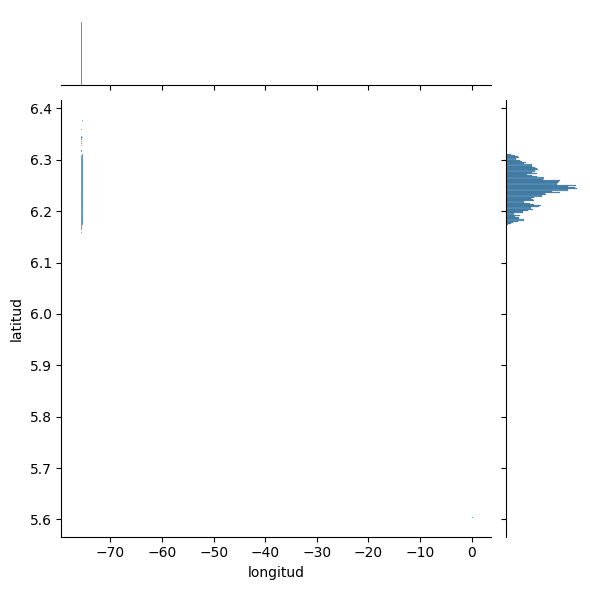

In [10]:
# Generate scatter plot
sns.jointplot(x="longitud", y="latitud", data=db, s=0.5)

In [8]:
db[['longitud', 'latitud']].describe()

,longitud,latitud
count,38343.000000,38343.000000
mean,-75.571624,6.245523
std,0.863400,0.031136
min,-75.709227,5.605000
25%,-75.599618,6.226033
50%,-75.583442,6.246407
75%,-75.561705,6.265323
max,-0.000679,6.377163


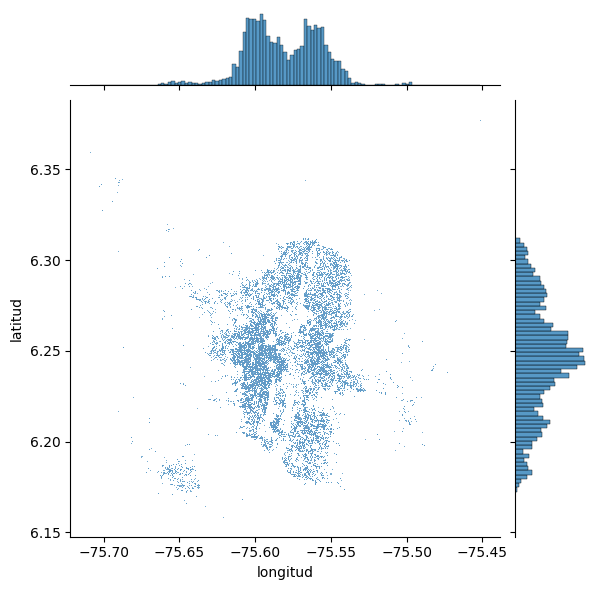

In [9]:
# Generate scatter plot
sns.jointplot(x="longitud", y="latitud", data=db[db['longitud']<-50], s=0.5)

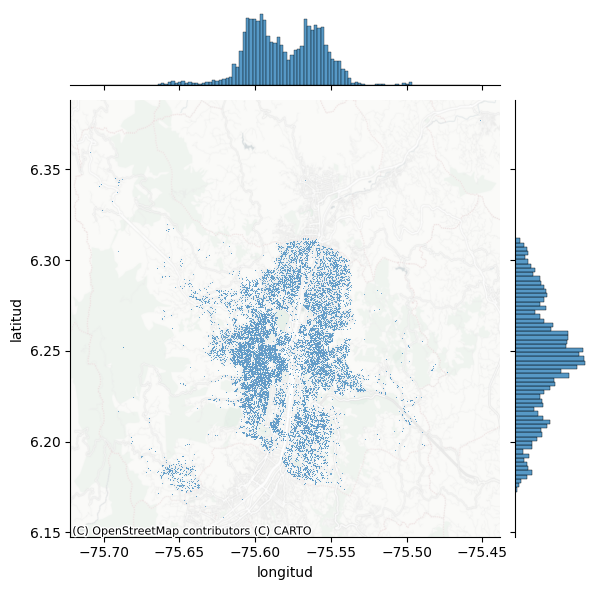

In [11]:
# Generate scatter plot
joint_axes = sns.jointplot(
    x="longitud", y="latitud", data=db[db['longitud']<-50], s=0.5
)
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
)

In [12]:
db=db[db['longitud']<-50].copy()

## Visualización de la densidad con hexbinning

Aquí, generamos una cuadrícula regular (ya sea cuadrada o hexagonal), contamos cuántos puntos caen dentro de cada celda y la presentamos como cualquier otro mapa coroplético. Si la cuadrícula regular es lo suficientemente fina, elimina algunas de las distorsiones de área que pueden inducir los mapas coropléticos.

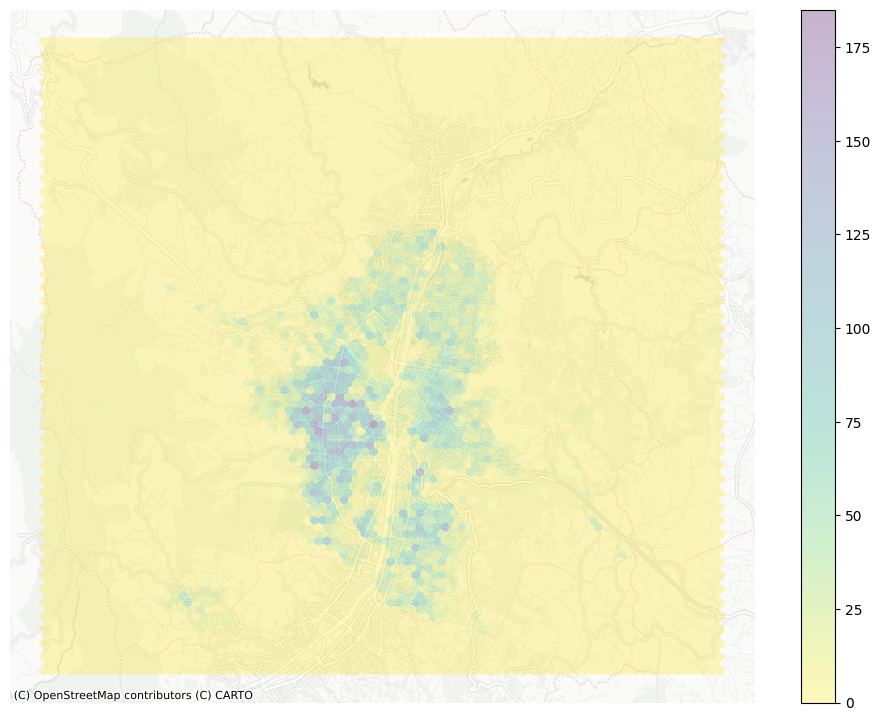

In [ ]:
# Convertir a GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857) ## Los mapas base de contextily usan EPSG:3857

# Crear figura
f, ax = plt.subplots(1, figsize=(12, 9))

# Hexbin
hb = ax.hexbin(
    gdf.geometry.x,
    gdf.geometry.y,
    gridsize=80, # Divide el ancho total del mapa (mín_x → máx_x) en 80 columnas de hexágonos 
    linewidths=0,
    alpha=0.3,
    cmap="viridis_r",
)

# Basemap en el mismo axis
contextily.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=contextily.providers.CartoDB.PositronNoLabels,
)

# Colorbar
plt.colorbar(hb, ax=ax)

# Quitar ejes
ax.set_axis_off()

plt.show()

## Estimación de densidad kernel
Un KDE 2D genera una “superficie” de densidad, y Seaborn la representa visualmente mediante contornos y rellenos tipo isodensidad (Línea o superficie que conecta puntos con la MISMA densidad).

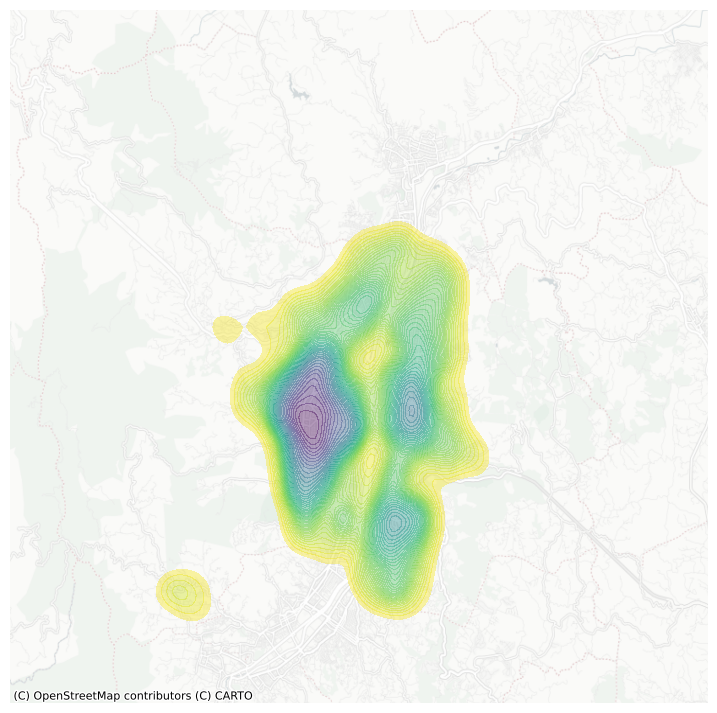

In [ ]:
# Convertir a GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Estimación de densidad kernel
f, ax = plt.subplots(1, figsize=(9, 9))
sns.kdeplot(
    x=gdf.geometry.x,
    y=gdf.geometry.y,
    data=db,
    n_levels=50, # Define cuántas curvas de nivel de densidad 
    fill=True,
    alpha=0.4,
    cmap="viridis_r",
)
# Add basemap
# Basemap en el mismo axis
contextily.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Remove axes
ax.set_axis_off()

## Centrografía
La centrografía es el análisis de la centralidad en un patrón de puntos. Por "centralidad" entendemos la ubicación general y la dispersión del patrón.

### Tendencia 
Una medida común de tendencia central para un patrón de puntos es su centro de masa. Para patrones de puntos marcados, el centro de masa identifica un punto central cercano a las observaciones con valores más altos en el atributo marcado. Para patrones de puntos no marcados, el centro de masa equivale al centro medio, o promedio de los valores de las coordenadas.

In [31]:
mean_center = centrography.mean_center(db[["longitud", "latitud"]])
med_center = centrography.euclidean_median(db[["longitud", "latitud"]])

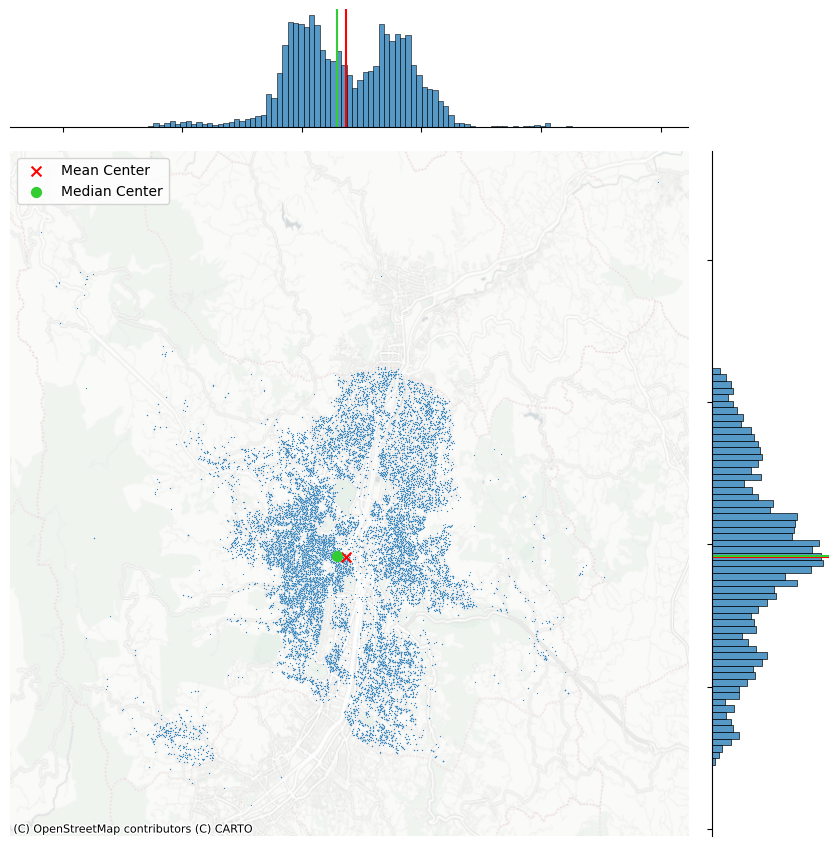

In [37]:
# Generate scatterplot
joint_axes = sns.jointplot(
    x="longitud", y="latitud", data=db, s=0.75, height=9
)
# Add mean point and marginal lines
joint_axes.ax_joint.scatter(
    *mean_center, color="red", marker="x", s=50, label="Mean Center"
)
joint_axes.ax_marg_x.axvline(mean_center[0], color="red")
joint_axes.ax_marg_y.axhline(mean_center[1], color="red")
# Add median point and marginal lines
joint_axes.ax_joint.scatter(
    *med_center,
    color="limegreen",
    marker="o",
    s=50,
    label="Median Center"
)
joint_axes.ax_marg_x.axvline(med_center[0], color="limegreen")
joint_axes.ax_marg_y.axhline(med_center[1], color="limegreen")
# Legend
joint_axes.ax_joint.legend()
# Add basemap
contextily.add_basemap(
    joint_axes.ax_joint,
    crs="EPSG:4326",
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Clean axes
joint_axes.ax_joint.set_axis_off()
# Display
plt.show()

### Dispersión
Una medida de dispersión común en centrografía es la distancia estándar . Esta medida proporciona la distancia promedio al centro de la nube de puntos (medida, por ejemplo, por el centro de masa).

In [ ]:
# Dispersión estandar en grados
centrography.std_distance(db[["longitud", "latitud"]])

0.039215422077184384

In [39]:
# teniendo en cuenta que 1 grado es aproximadamente 101 km
centrography.std_distance(db[["longitud", "latitud"]]) * 101


3.960757629795623

#### Elipse de desviación estándar

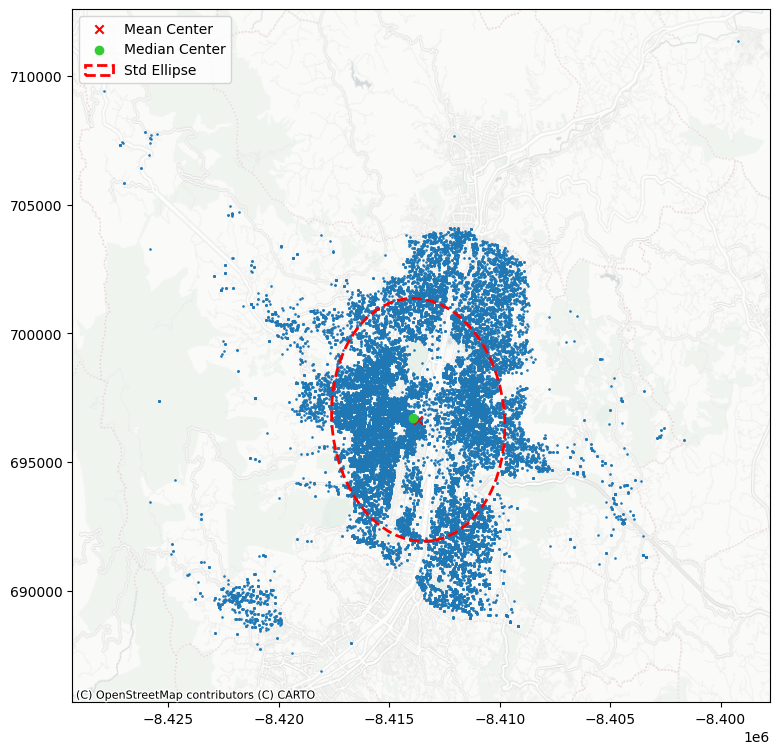

In [47]:
# 1. Crear GeoDataFrame y reproyectar
gdf = gpd.GeoDataFrame(
    db,
    geometry=gpd.points_from_xy(db["longitud"], db["latitud"]),
    crs="EPSG:4326"
).to_crs(3857)

# Extraer coordenadas en 3857
gdf["x"] = gdf.geometry.x
gdf["y"] = gdf.geometry.y

# 2. Recalcular mean y median center en metros
mean_center = (gdf["x"].mean(), gdf["y"].mean())
med_center  = (gdf["x"].median(), gdf["y"].median())

# 3. Elipse de desviación estándar EN 3857
major, minor, rotation = centrography.ellipse(gdf[["x", "y"]])

# 4. Graficar
fig, ax = plt.subplots(figsize=(9,9))

ax.scatter(gdf["x"], gdf["y"], s=0.75)
ax.scatter(*mean_center, color="red", marker="x", label="Mean Center")
ax.scatter(*med_center, color="limegreen", marker="o", label="Median Center")

# Construir elipse correctamente proyectada
ellipse = Ellipse(
    xy=mean_center,
    width=major * 2,
    height=minor * 2,
    angle=np.degrees(rotation),
    facecolor="none",
    edgecolor="red",
    linestyle="--",
    linewidth=2,
    label="Std Ellipse"
)

ax.add_patch(ellipse)
ax.legend()

# 5. Basemap correcto
contextily.add_basemap(
    ax,
    crs="EPSG:3857",
    source=contextily.providers.CartoDB.PositronNoLabels
)

plt.show()